In [1]:
import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
import numpy as np
import time

import cv2 
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
import time
from math import sqrt
from skimage import transform
import skimage 

In [2]:
# functions 

circle = lambda r: np.array([[sqrt((i-r)**2 + (j-r)**2) <= r for j in range(0, 2*r+1)] for i in range(0, 2*r+1)])

def absolute(x, y):
    return(math.sqrt(x**2 + y**2))
vect_absolute = np.vectorize(absolute)

def power(input):
    return input**2
vect_power = np.vectorize(power)

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

def calc_dist(histogram, x, y):
    dist = histogram[x-1:x+2, y-1:y+2] - histogram[x,y]
    # base = histogram[x][y]
    # rep_base = np.tile(base,(3, 1))
    # extended_base = np.ndarray((3, 3, 10))
    # extended_base[:] = rep_base
    # dist = (extended_base - histogram[x-1:x+2, y-1:y+2])
    dist = np.power(dist, 2)
    dist = np.sum(dist, axis=2)
    dist = np.sqrt(dist)
    dist = np.sum(np.sum(dist))
    return dist

def ZMUV(img):
    """global zero mean unit variance (ZMUV) normalization"""
    img = img - np.mean(img)
    return img/np.std(img)

def histEq(image, number_bins=256):

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def plot(img):
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(img, 'gray')

# M1 
# The variance of the greylevel histogram over a circular neighbourhood
# of radius 3 (total area N = 29 pixels) at each pixel is used as a measure of how much local information there is:
def calc_M1(img):
    width, height = img.shape
    bins = 10
    histogram = np.ndarray((width, height, bins))
    hist_variance = np.zeros((width, height))
    radius = 3
    kernel = circle(radius)
    denominator = kernel.sum()
    img_force_int = img.astype('float')
    for x in range(radius, width-radius):
        for y in range(radius, height-radius):
            crop = img_force_int[x - radius:x + radius + 1, y - radius:y + radius + 1]
            croped_crop = crop[kernel]
            hist, _ = np.histogram(croped_crop, bins)
            histogram[x, y] = hist
#             var = np.nanvar(histogram[x, y])
#             hist_variance[x][y] = var
    hist_variance = np.nanvar(histogram, axis=2)
    M1 = hist_variance
    return M1, histogram

# M2
# Text regions have a high density of edges. This density is measured in a circular neighbourhood of 
# radius 6 centred at each pixel by summing all edge magnitudes located with a Sobel filter:
def calc_M2(img):
    G = np.empty(img.shape[:2] + (2,))
    Gx_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy_kernel = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    G[...,0] = signal.convolve2d(img, Gx_kernel, 'same')
    G[...,1] = signal.convolve2d(img, Gy_kernel, 'same')
    G = np.linalg.norm(G, axis=2)
    G = G.astype(np.uint8)
    # sum all edge magnitudes 
    kernel = circle(6)
    M2 = signal.convolve2d(G, kernel, 'same')
    
    return M2

# M3
# the ratio of text to non-text intensity greylevels should not vary greatly as we pass over a text region.
# hypothesise that there will be only a small change in local greylevel histograms across a text region.
def calc_M3(histogramFromM1):
    width, height, bins = histogramFromM1.shape
    rowpdist = np.linalg.norm(histogramFromM1[:-1]-histogramFromM1[1:], axis=2)
    colpdist = np.linalg.norm(histogramFromM1[:,:-1]-histogramFromM1[:,1:], axis=2)
    tracepdist = np.linalg.norm(histogramFromM1[:-1,:-1]-histogramFromM1[1:,1:], axis=2)
    ecartpdist = np.linalg.norm(histogramFromM1[:-1,1:]-histogramFromM1[1:,:-1], axis=2)
    
    M3 = np.zeros((width, height))
    for x in range(1, width-2):
        for y in range(1, height-2):
            dist = np.sum(rowpdist[x, y-1:y+1]) + np.sum(colpdist[x-1:x+1, y]) + tracepdist[x-1, y-1] + tracepdist[x, y] + ecartpdist[x, y-1] + ecartpdist[x-1, y]
#             dist = calc_dist(histogramFromM1, x, y)
            M3[x][y] = dist
    return M3

# M4
# In high resolution images one expects to find a high number of edges in a text region, and 
# the angles of the edges to be well distributed due to the presence of curves on many characters. 
# However, this will not be the case at low resolution, where individual characters merge and edges follow
# the tops and bottoms of text lines.
def calc_M4(img):
    
    width, height = img.shape
    angle = 0
    radius = 6
    bins = 8
    kernel = circle(radius)
    
    circle_count = np.sum(kernel)

    # calculate magnitude vector
    Gx_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy_kernel = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = signal.convolve2d(img, Gx_kernel, 'same')
    Gy = signal.convolve2d(img, Gy_kernel, 'same')
    Gvector = np.ndarray([2, width, height])
    Gvector[0, ...] = Gx
    Gvector[1, ...] = Gy
    magnitude = np.linalg.norm(Gvector, axis=0)
    # calculate angles of magnitude
    magnitude_angle = np.arctan2(Gx, Gy)

    histograms = np.ndarray((width, height, 2, bins))
    M4 = np.ndarray((width, height))
    for x in range(radius, width - radius):
        for y in range(radius, height - radius):
            crop = magnitude_angle[(x - radius):(x + radius + 1), (y - radius):(y + radius + 1)]
            cropped_with_kernel = crop[kernel]
            cropped_with_kernel = cropped_with_kernel.reshape(cropped_with_kernel.size, 1)
            # mapp instances of 0 < x <= pi to 1 and pi < x <= 2pi to 0           
#             mapp = np.logical_and(0 < cropped_with_kernel, cropped_with_kernel <= math.pi)
            # crop_1 is the angles from 0  to  pi
#             crop_1 = cropped_with_kernel[mapp]
            # crop_2 is the angles from pi to 2pi                 
#             crop_2 = cropped_with_kernel[np.logical_not(mapp)]

            hist_total, _ = np.histogram(cropped_with_kernel, bins=16, range=(-np.pi, np.pi))
#             print hist
            hist = np.subtract(hist_total[-8:], hist_total[:8])**2
#             hist = (hist_total[-8:] - hist_total[:8])**2
#             print circle_count
#             print np.sum(hist)
            M4[x, y] = np.sum(hist) / circle_count
            # when the size of either part is zero we create a "zero" histogram,
            # an array of zeros the size of the number of bins(in this case 8)
#             if (crop_1.size == 0):
#                 histogram_1 = np.zeros(8)
#                 histogram_2, trash = np.histogram(np.hstack(crop_2),bins)
#             elif (crop_2.size == 0):
#                 histogram_1, trash = np.histogram(np.hstack(crop_1),bins)
#                 histogram_2 = np.zeros(8)
#             else: 
#                 histogram_1, trash = np.histogram(np.hstack(crop_1),bins)            
#                 histogram_2, trash = np.histogram(np.hstack(crop_2),bins)
                
#             diff = histogram_1 - np.flipud(histogram_2)
#             M4[x, y] = np.linalg.norm(diff)
            
#             histograms[x, y, 0] = histogram_1
#             histograms[x, y, 1] = histogram_2
            histograms[x, y, 0] = hist_total[-8:]
            histograms[x, y, 1] = hist_total[:8]
        
    return M4, histograms

# M5
# The first four measures respond in the same way to straight image features as to coarse or curved features. 
# This measure is employed to reject those areas of the image with tight distributions
# of edges corresponding to straight ramps, canals or ridges in the image. 
# It examines how evenly spread the edge magnitudes are over all the directions:

# use histograms calculated in M4
def calc_M5(histogramFromM4):
    bins = 8
    width, height, trash, trash = histogramFromM4.shape
    pi = math.pi
    M5 = np.ndarray((width, height))
    for x in range(0, width):
        for y in range(0, height):
            histogram_1 = histogramFromM4[x, y, 0]
            histogram_2 = histogramFromM4[x, y, 1]
            local_average = (sum(histogram_1) + sum(histogram_2))/(bins*2)
            result = 0
            for theta in range(0, 8):
                result += (local_average - histogram_1[theta])**2
                result += (local_average - histogram_2[theta])**2
            M5[x, y] = result

    return M5
    
def scaleTo255(img):
    return (img - np.amin(img) ) * 255 / (np.amax(img) - np.amin(img))

def prepImg(fileName, scale):
    img = cv2.imread(fileName, 0)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    img_rescaled = get_rescaled(dst, scale)    
    return img_rescaled
    
def calcFilters(fileName, scale):
    start = time.time()
    img = prepImg("./training/img/"+fileName, scale)
        
    M1, histogramFromM1  = calc_M1(img)
    print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M1"
    start = time.time()
    
    M2 = calc_M2(img)
    print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M2"
    start = time.time()
    
    M3 = calc_M3(histogramFromM1)
    print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M3"
    start = time.time()
    
    M4, histogramFromM4 = calc_M4(img)
    print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M4"
    start = time.time()
    
    M5 = calc_M5(histogramFromM4)
    print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M5"
    start = time.time()
    
    filters = [M1, M2, M3, M4, M5]
    
    for idx in range(0, len(filters)):
        cv2.imwrite( "./training/filters/img/"+fileName+"_M"+str(idx + 1)+".jpg", scaleTo255(filters[idx]));

    # plot result 
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(img, 'gray')
    
    return [M1, M2, M3, M4, M5]

def inverse(img):
    return np.abs(img - 1)

def threshold(img):
    thresh = np.mean(img)
    img[img > thresh] = 1
    img[img <= thresh] = 0
    return img

def combineFilters(M1, M2, M3, M4, M5):
    # PART II takes less time, copy filters -- do not destroy variables.
    M1cp = M1
    M2cp = M2
    M3cp = M3
    M4cp = M4
    M5cp = M5

    # normalize each filter to zero mean and standard deviation 1
    M1norm = ZMUV(M1cp)
    M2norm = ZMUV(M2cp)
    M3norm = ZMUV(M3cp)
    M4norm = ZMUV(M4cp)
    M5norm = ZMUV(M5cp)

    # threshhold each image with cutoff mean
    M1thresh = threshold(M1norm)
    M2thresh = threshold(M2norm)
    M3thresh = threshold(M3norm)
    M4thresh = threshold(M4norm)
    M5thresh = threshold(M5norm)

    # combine filters
    combine = inverse(M1thresh) + M2thresh + inverse(M3thresh) + inverse(M4thresh) + inverse(M5thresh)
    combine[combine < 5] = 0
    combine[combine == 5] = 1
    
    # plot filters    
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(M1, 'gray')
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(M2, 'gray')
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(M3, 'gray')
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(M4, 'gray')
    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(M5, 'gray')

    plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(combine, 'gray')

    return combine    

def useFilters(filename, scale):
    filters = calcFilters(filename, scale)
    combine = combineFilters(filters[0], filters[1], filters[2], filters[3], filters[4])
    combine255 = scaleTo255(combine)
    cv2.imwrite( "./training/preprocess/"+filename[:-4]+"_combined.jpg", combine255);

In [8]:

filename = 'img0.png'
scale = 0.2
useFilters(filename, scale)

img0


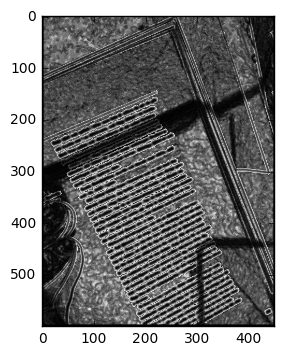

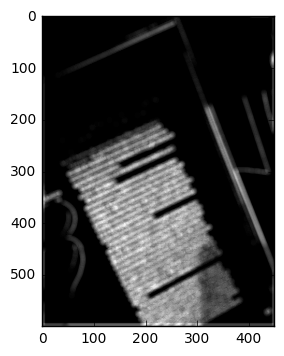

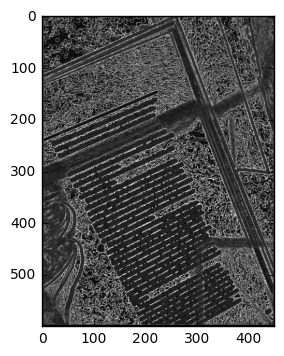

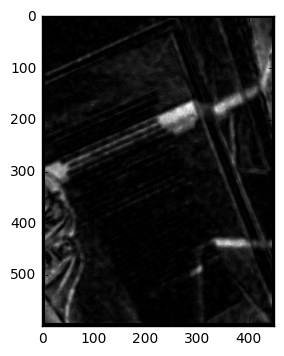

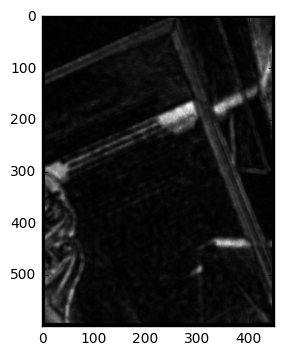

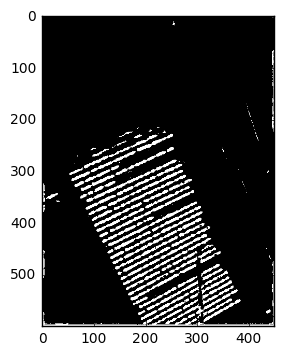

In [ ]:
img = prepImg('./img/bok11.png', 0.2)
print np.amax(img)
print np.amin(img)

scaled = scaleTo255(img)
print np.amax(scaled)
print np.amin(scaled)

imgName = "img0"
image = cv2.imread("./training/filters/img/"+imgName+"_input.jpg", 0)

norm = ZMUV(image)
# print np.amax(norm)
# print np.amin(norm)
cv2.imwrite( "./training/filters/img/img0_input.jpg", scaleTo255(scaled));